# Assignment 5 - Deep Learning for Image Analysis

## Deadline: Thursday, November 28 at 11:59 PM
## The assignment must be submitted in the form of a Jupyter notebook and uploaded to eClass.

## Marks:
- Step 1: Load and explore dataset. 1 mark.
- Step 2: Implement a custom dataset constructor with transformations. 1.5 mark.
- Step 3: Custom dataloaders for the dHCP data. 1 mark.
- Step 4: Define the architecture of a CNN for segmentation. 2 marks.
- Step 5: Implement the Dice loss. 1.5 marks.
- Step 6: Train the CNN. 2 marks.
- Step 7: Predict on the test set and visualize. 1 mark.

**Total: 10 marks**


**Bonus:**
Steps 8 to 10 are optional, for 3 additional bonus points.
- Step 8: Implement Early Stopping and retrain the network. Save the best model. 1 mark.
- Step 9: Implement a model with Batch Normalization and Early Stopping and retrain the network. Save the best model. 1 mark.
- Step 10: Compare the performance on the test set with and without batch normalization and discuss briefly (200 words max.). 1 mark.


**Total: 3 marks**


We will revisit the developing Human Connectome Project dataset we used to predict the gestational age of preterm babies using brain structure volumes. Our task will now be the segmentation of 2D axial slices of T2-weighted brain MRI images.

**Note:** make sure to import all necessary modules and that the notebook runs sequentially without errors.


**Note:** The provided code assumes you'll be taking advantage of GPUs. If you decide to work on CPUs, you will not need the `.to(device)` command to send data, model, and loss function to the `cuda` device, and you won't need to use the `.cpu()` command to get the outputs. The training will take longer (roughly 1-2 minutes per epoch).

In [37]:
# This will allow the network to run on GPUs
# Make sure to change the runtime type to GPUs so that the output of these commands is 'cuda'

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cuda


## Step 1: Load and explore dataset

### Extract the data

Run the code below to extract the data. Remember to load `mrimages.zip` to your Colab session.



In [38]:
# Extract the dHCP dataset to the current directory

import zipfile

with zipfile.ZipFile('mrimages.zip', 'r') as zip_ref:
  zip_ref.extractall()

### Visualize

The extracted `mridata` folder contains T2 images (`imgNumber_t2w.jpg`) and corresponding tissue segmentations (`imgNumber_lab.jpg`).

Visualize an example image and its segmentation.


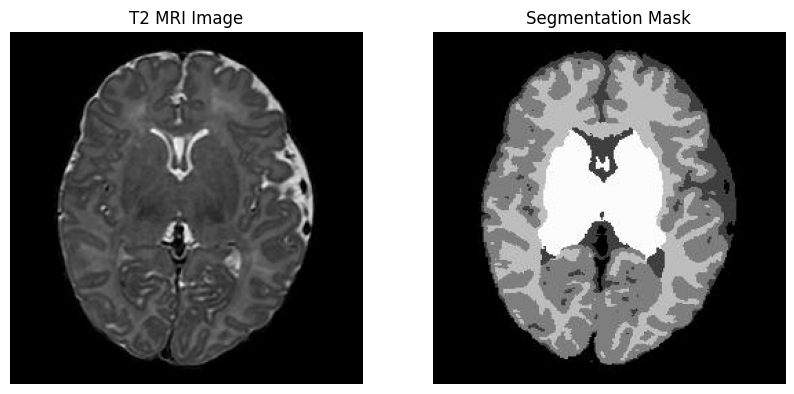

In [39]:
# Visualize a T2 image and the corresponding segmentation

import matplotlib.pyplot as plt
from PIL import Image

#Choose an example index
idx = 1

#Build correct paths
img_path = f"mridata/{idx}_t2w.jpg"
seg_path = f"mridata/{idx}_lab.jpg"

#Load the images
im = Image.open(img_path)
seg = Image.open(seg_path)

#Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im, cmap='gray')
plt.title("T2 MRI Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(seg, cmap='gray')
plt.title("Segmentation Mask")
plt.axis('off')

plt.show()

### Explore segmentation

How many labels do you expect we will need to predict to match the segmentation? You can answer based on visual inspection of the segmented images.

Based on visual inspection, the segmented images appear to have one main labeled region (white area) corresponding to the brain, with the rest being background. Therefore, I expect there are 2 labels: background and brain.


Now, print the number of unique values in the segmented image. Does it correspond to the number of expected labels?
Print the minimum and maximum value of the segmented image.

In [40]:
# Number of unique values, minimum and maximum value in the segmented image
import numpy as np

#Choose one seg file to inspect
seg_path = "mridata/1_lab.jpg"

#Load image as array
seg = np.array(Image.open(seg_path).convert('L'))

#Compute statistics
unique_values = np.unique(seg)
min_value = seg.min()
max_value = seg.max()

print("Number of unique values:", unique_values)
print("Minimum value:", min_value)
print("Maximum value:", max_value)

Number of unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  31  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 217 218 220
 221 222 224 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 2

### Explore image size

Explore the shape of the input images and segmentations: are they grayscale or RGB?

In [41]:
# Explore the shape of the T2 images
# Pick any T2 image in your dataset
img_path = "mridata/1_t2w.jpg"

img = np.array(Image.open(img_path))

print("T2 image shape:", img.shape)

# Interpretation
if len(img.shape) == 2:
    print("This T2 image is: Grayscale (1 channel)")
elif len(img.shape) == 3 and img.shape[2] == 3:
    print("This T2 image is: RGB (3 channels)")
else:
    print("Unknown format")


T2 image shape: (256, 256)
This T2 image is: Grayscale (1 channel)


### Explore metadata

Three `csv` files are provided for the train/validation/test split:

1. `data_train.csv`  - data used for training
2. `data_valid.csv`  - data used for validation
3. `data_test.csv`   - data used for test

Load one of them and note how they are structured.


In [42]:
import pandas as pd

# Load one CSV, e.g., training set
csv_path = "data_train.csv"
df_train = pd.read_csv(csv_path)

#Check the first 5 rows
print("First 5 rows of the CSV:")
print(df_train.head())

#Check columns
print("\nCSV columns:")
print(df_train.columns)

#Check the total number of samples
print("\nNumber of samples:", len(df_train))


First 5 rows of the CSV:
  image_name   ga_birth   pma_scan
0  1_t2w.jpg  41.142857  41.285714
1  2_t2w.jpg  40.142857  40.285714
2  3_t2w.jpg  41.142857  41.428571
3  4_t2w.jpg  41.285714  41.571429
4  5_t2w.jpg  38.571429  38.857143

CSV columns:
Index(['image_name', 'ga_birth', 'pma_scan'], dtype='object')

Number of samples: 324


## Step 2: Implement a custom dataset constructor with transformations






We will create a custom constructor implementing the following transformations:

1. Rescale both the image and the segmentation.

2. Split the labels of segmentation data, which has size Nx x Ny, to create a new array of size 5 x Nx x Ny. This is because we want each segmentation label (white matter, grey matter, etc.) to be on a separate channel, with values between 0 and 1.

3. Normalize the pixel intensities so they lie in the range [0, 1].

In [43]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import Resize
import os

class DHCPDataset(Dataset):

  def __init__(self, csv_file, folder_input='mridata/', rescale=True, normalize=True, split=True):
    """
    Args:
    csv_file: a csv file with image name | age at birth | age at scan
    """
    self.data_file = pd.read_csv(csv_file)
    self.folder_input = folder_input
    self.rescale = rescale
    self.normalize = normalize
    self.split = split

  def __len__(self):
    """
    Number of samples inside the dataset
    Returns: length of dataset
    """
    return len(self.data_file)  # Complete this line

  def rescale_data(self, image, seg, size=(128, 128)):
    """
    Rescale image and segmentation to desired size.
    size (tuple or int): desired output size. If tuple, output is
          matched to output_size. If int, smaller of image edges is matched
          to output_size, maintaining the aspect ratio.
    """
    resize_transform = Resize(size)
    #Convert numpy array to PIL image for resizing
    image = Image.fromarray((image*255).astype(np.uint8))
    seg = Image.fromarray(seg.astype(np.uint8))
    #Apply resize
    image = np.array(resize_transform(image)) / 255.0 #scale back to [0, 1]
    seg = np.array(resize_transform(seg))
    return image, seg


  def split_labels(self, seg):
    """
    Split the labels of segmentation data, which has size Nx x Ny,
    to create a new array of size 5 x Nx x Ny.
    """
    # Labels should lie in the range [0, 4]
    seg = seg / 63

    nx, ny = seg.shape  # Complete this line
    new_seg = np.zeros((5, nx, ny), dtype=np.float32)

    # Split channels
    # The segmented mask contains labels 0 to 4 in one single channel
    # We want to split it into 5 channels, each dedicated to a label, and binarize each channel
    for i in range(5):
      temp_seg = (seg == i).astype(np.float32)  # binarize each label
      new_seg[i] = temp_seg

    return torch.from_numpy(new_seg).float()


  def normalize_data(self, image):
    """
    Normalize image intensities between [0, 1]
    """
    image = image.astype(np.float32)
    image = image / 255.0
    return torch.from_numpy(image).unsqueeze(0) # add channel dimension


  def __getitem__(self, idx):
    """
    Select an individual sample from the dataset

    Args:
      idx: index of sample to draw

    Return:
      Dict[str, torch.Tensor]: single sample
        * `image`: image data
        * `seg`: segmentation data
        * `ga_birth`: age at birth
        * `ga_scan`: age at scan
    """

    # Read T2 image name from column 0
    image_name = os.path.join(self.folder_input, self.data_file.iloc[idx]['image_name'])

    # Get segmentation image name by substituting _t2w.jpg with _lab.jpg in the filename
    lab_name = image_name.replace('_t2w', '_lab')

    # Age at birth and age at scan are on the second and third columns
    baby_age_birth = self.data_file.iloc[idx]['ga_birth']
    baby_age_scan = self.data_file.iloc[idx]['pma_scan']

    # Load images as numpy arrays
    image = np.array(Image.open(image_name).convert('L'))
    seg = np.array(Image.open(lab_name).convert('L'))

    #Apply transforms
    if self.rescale:
      image, seg = self.rescale_data(image, seg)

    if self.split:
      seg = self.split_labels(seg)

    if self.normalize:
      image = self.normalize_data(image)

    # Create sample
    sample = {'image': image,
              'seg': seg,
              'ga_birth': torch.tensor(baby_age_birth, dtype=torch.float32),
              'ga_scan': torch.tensor(baby_age_scan, dtype=torch.float32)}

    return sample


## Step 3: Custom dataloaders for the dHCP data

- Create X_train, X_valid, and X_test by calling DHCPDataset with the corresponding .csv file;

- Create the dataloaders for each type.




Image_train.shape: torch.Size([8, 1, 128, 128])
Label_train.shape: torch.Size([8, 5, 128, 128])


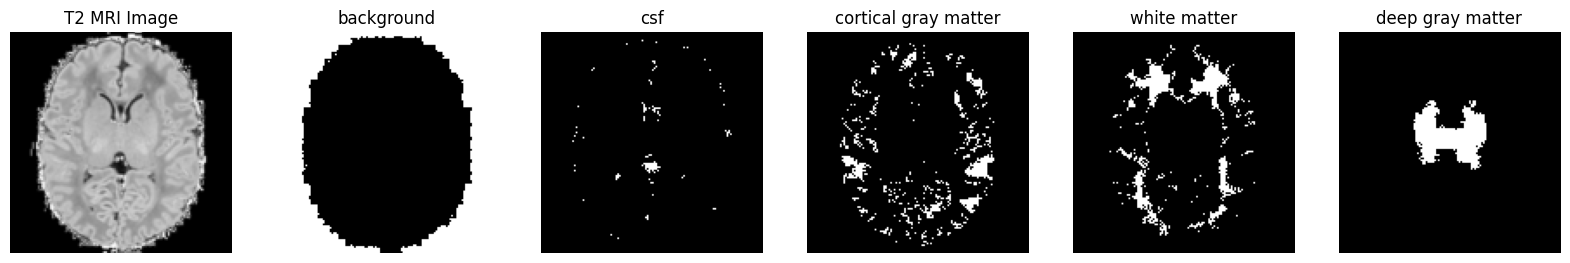

...


Image_train.shape: torch.Size([8, 1, 128, 128])
Label_train.shape: torch.Size([8, 5, 128, 128])


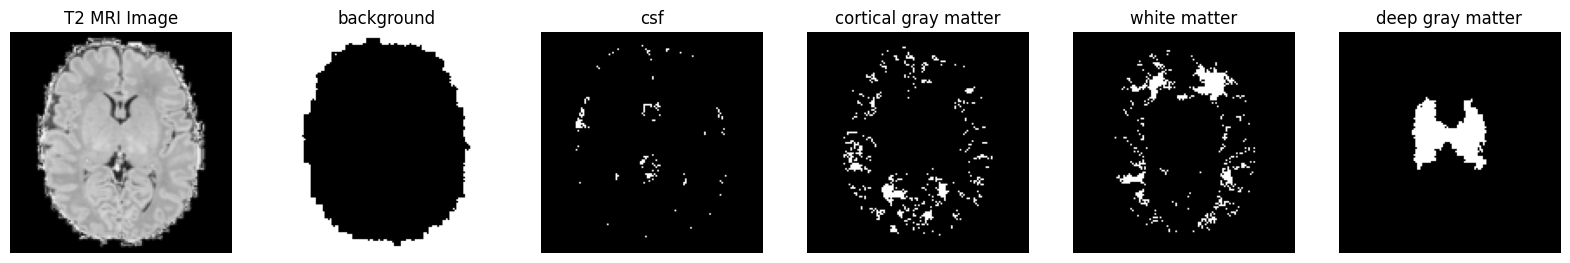

...


Image_train.shape: torch.Size([8, 1, 128, 128])
Label_train.shape: torch.Size([8, 5, 128, 128])


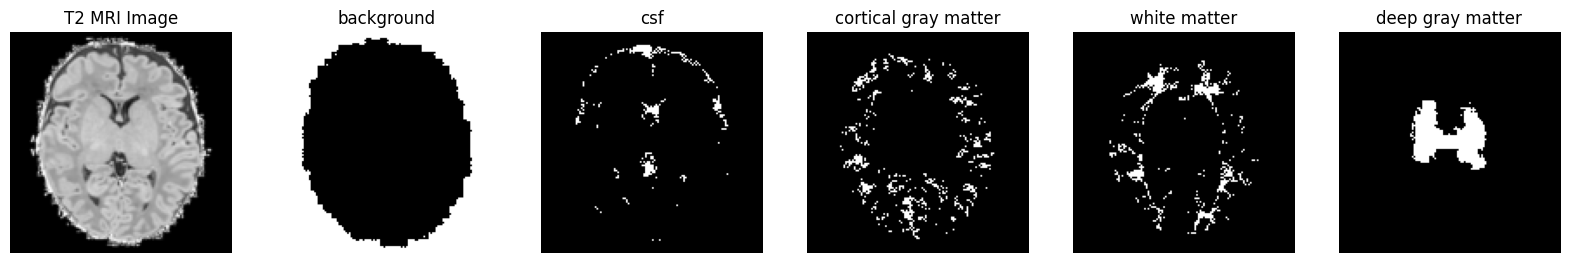

...


In [44]:
from torch.utils.data import DataLoader
# Dataset properties
batch_size = 8
LABELS_DICT = {0: 'background', 1: 'csf', 2: 'cortical gray matter', 3: 'white matter', 4: 'deep gray matter'}

# Train / validation / test datasets
X_train = DHCPDataset(csv_file='data_train.csv', folder_input='mridata/')
X_valid = DHCPDataset(csv_file='data_valid.csv', folder_input='mridata/')
X_test = DHCPDataset(csv_file='data_test.csv', folder_input='mridata/')

# Train / validation / test dataloaders
dataloaders = {
    "train": DataLoader(X_train, batch_size=batch_size, shuffle=True),
    "valid": DataLoader(X_valid, batch_size=batch_size, shuffle=True),
    "test": DataLoader(X_test, batch_size=batch_size, shuffle=True)
}

# Let's check the training loader
for i, batch in enumerate(dataloaders["train"]):
  image_train, label_train = batch['image'], batch['seg']
  print('\n\nImage_train.shape:', image_train.shape)
  print('Label_train.shape:', label_train.shape)

  plt.figure(figsize=(20, 3))
  plt.subplot(1, 6, 1)
  # Plot the training image
  plt.imshow(image_train[0, 0].numpy(), cmap='gray')
  plt.title("T2 MRI Image")
  plt.axis('off')

  for idx in np.arange(0, 5):
    plt.subplot(1, 6, idx+2)
    # Plot the 5 channels of the segmentation
    plt.imshow(label_train[0, idx].numpy(), cmap='gray')
    plt.title(LABELS_DICT[idx])
    plt.axis('off')
  plt.show()

  print('...')

  # Break the loop early as we only want to look at a few examples:
  if i > 1:
    break


## Step 4: Define the architecture of a CNN for segmentation

We will implement a network architecture loosely based on the U-Net (more info about it [here](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)).


Implement the following architecture:
  1. Three convolutional layers, each followed by a [LeakyReLU activation](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) (use `inplace=True`) and an average pooling layer:
    * The first convolution goes from `in_channels=1` (because the input image has 1 channel) to `out_channels=32`;
    * The second goes from 32 to 64 features;
    * The third goes from 64 to 128 features.
    * Keep `kernel_size=3` and `padding=1` for all convolutions.
    
  2. Three [transpose convolutional layers](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), each followed by a LeakyReLU activation and an [Upsampling layer](https://pytorch.org/docs/stable/generated/torch.nn.UpsamplingBilinear2d.html):
    * The first convolution goes from 128 to 64 features;
    * The second goes from 64 to 32 features;
    * The third goes from 32 to 16 features.
    * Keep `kernel_size=3` and `padding=1` for all convolutions.

  3. One final convolutional layer going from 16 to `out_nodes`, followed by a softmax activation for classification.
  
Here's a visual schematic of the architecture:
<img src="https://drive.google.com/uc?id=1FD8pYr7ATzEUDcWTaOQzF_1ub3zMY-hS" width="1000"/>

In [45]:
# CNN architecture

import torch.nn as nn
import torch.nn.functional as F

class MyConvNetwork(nn.Module):

  def __init__(self, in_channels=1, out_nodes=5):
    super(MyConvNetwork, self).__init__()

    self.conv = nn.Sequential(
       nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
       nn.LeakyReLU(inplace=True),
       nn.AvgPool2d(kernel_size=2),

       nn.Conv2d(32, 64, kernel_size=3, padding=1),
       nn.LeakyReLU(inplace=True),
       nn.AvgPool2d(kernel_size=2),

       nn.Conv2d(64, 128, kernel_size=3, padding=1),
       nn.LeakyReLU(inplace=True),
       nn.AvgPool2d(kernel_size=2)
    )

    self.transposed_conv = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(inplace=True),
        nn.Upsample(scale_factor=2, mode='nearest'),

        nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
        nn.LeakyReLU(inplace=True),
        nn.Upsample(scale_factor=2, mode='nearest'),

        nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
        nn.LeakyReLU(inplace=True),
        nn.Upsample(scale_factor=2, mode='nearest')
    )

    self.classifier = nn.Sequential(
        nn.Conv2d(16, out_nodes, kernel_size=3, padding=1),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    # Encoder
    x = self.conv(x)

    # Decoder
    x = self.transposed_conv(x)

    # Classifier
    x = self.classifier(x)

    return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyConvNetwork(in_channels=1, out_nodes=5).to(device)

#Test with a dummy input
dummy_input = torch.randn(1, 1, 128, 128).to(device)
dummy_output = model(dummy_input)
print("Output shape:", dummy_output.shape)

Output shape: torch.Size([1, 5, 128, 128])


## Step 5: Implement the Dice Loss




For segmentation tasks it is very common to use the Dice Loss.

For two binary volumes P (the predicted segmentation) and G (the ground truth segmentation), the Dice loss is defined as 1 - Dice Coefficent:

Dice Loss = $1 - DC$ = $ 1 - \frac{2 \sum_{i=1}^N p_i g_i}{\sum_{i=1}^N p_i + g_i + \epsilon} $

Where the voxels $p_i \in P$ and the voxels $g_i \in G$ and $\epsilon$ is added to avoid dividing by zero.

When the predicted and ground truth volumes are completely overlapping, DC = 1, thus the Dice Loss = 0.


Source: https://arxiv.org/pdf/1707.03237.pdf



Implement the Dice loss.

*Hints:*
  * Your `target_volume` and `predicted_volume` will have a shape of `Batches x Channels x Nx x Ny`. You can reshape them both to `Batches x Channels x Nx*Ny`.
  * The sum should be done on the voxels (`dim=2`).

In [46]:
class DiceLoss(torch.nn.Module):
    def init(self):
        super(DiceLoss, self).init()

    def forward(self, target_volume, predicted_volume, eps=1e-7):
      """
        Args:
            target_volume: [B, C, H, W] one-hot ground truth
            predicted_volume: [B, C, H, W] predicted probabilities (after softmax)
            eps: small number to avoid division by zero
      """
      # Reshape target and predicted volumes
      B, C, H, W = target_volume.shape
      target_volume = target_volume.view(B, C, -1)
      predicted_volume = predicted_volume.view(B, C, -1)

      # Calculate intersection and union
      intersection = torch.sum(target_volume * predicted_volume, dim=2)
      union = torch.sum(target_volume + predicted_volume, dim=2)

      # Calculate dice score
      dc = (2 * intersection) / (union + eps)

      # Calculate loss
      dc_loss = 1 - dc

      # Return micro average (to calculate the metric globally across all samples in the batch and across all classes)
      return torch.mean(dc_loss)

## Step 6: Train the CNN

Train the network with:
  * Dice loss
  * Adam optimizer
  * learning rate of 0.005

Epoch 0 - Loss on training set: 0.87, Loss on validation set: 0.87


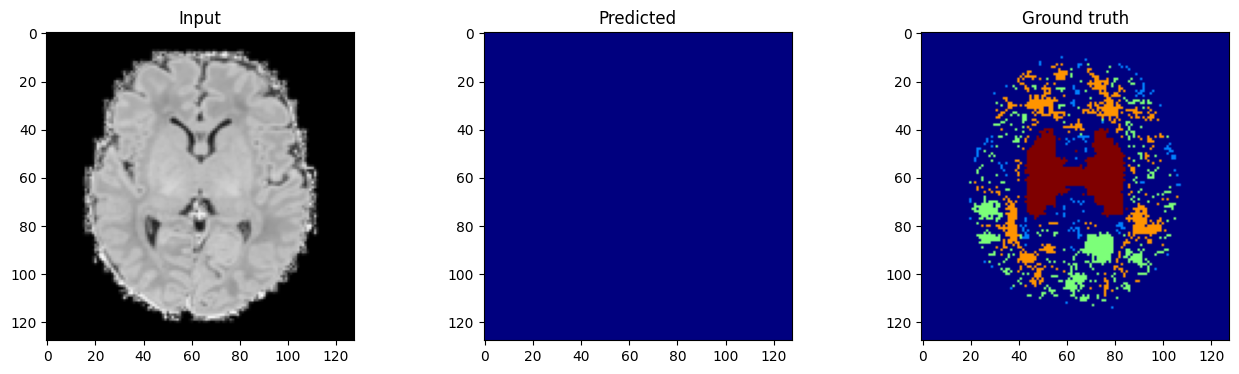

Epoch 5 - Loss on training set: 0.87, Loss on validation set: 0.87


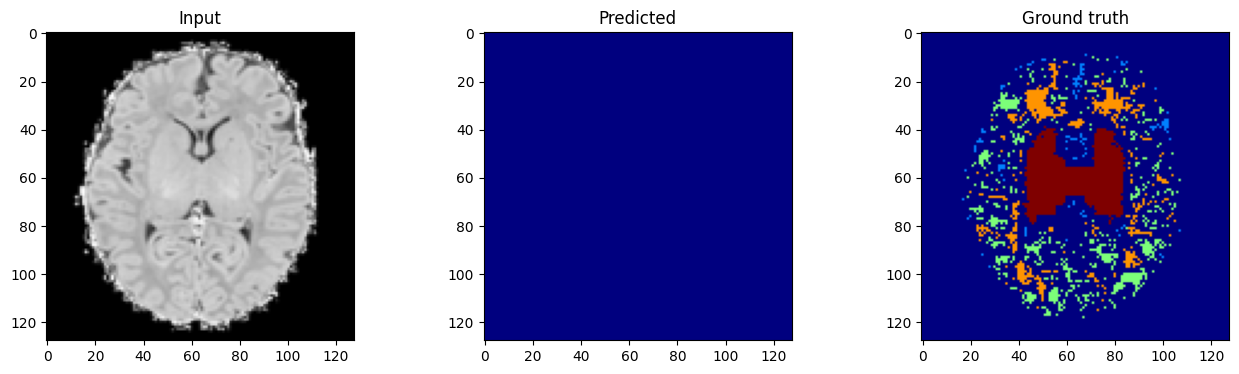

Epoch 10 - Loss on training set: 0.87, Loss on validation set: 0.87


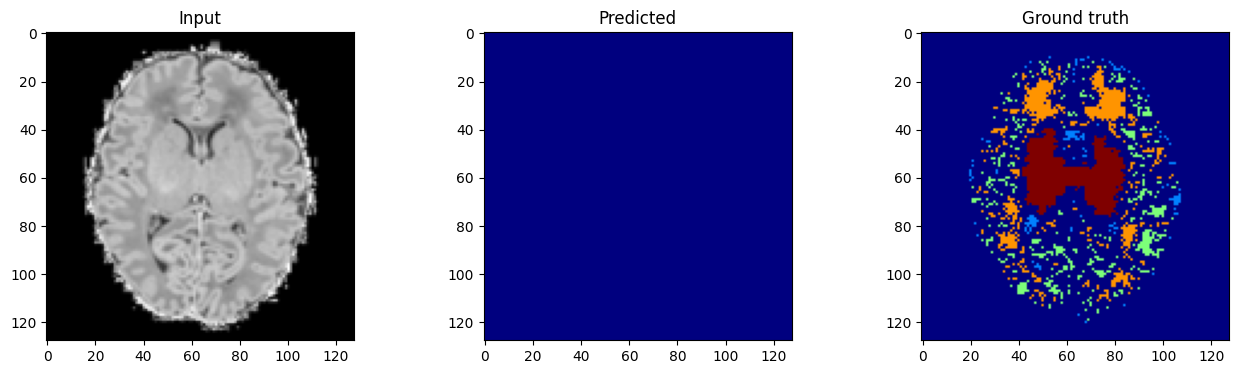

Epoch 15 - Loss on training set: 0.87, Loss on validation set: 0.87


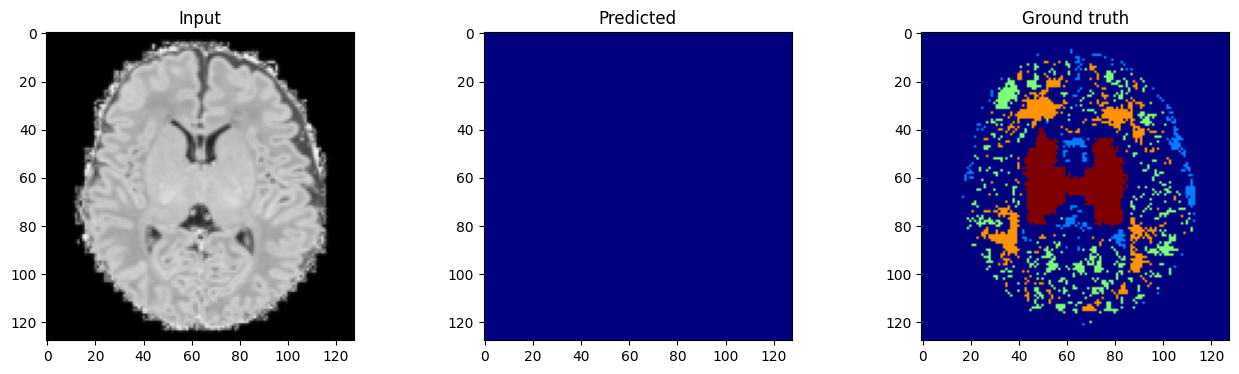

Epoch 20 - Loss on training set: 0.87, Loss on validation set: 0.88


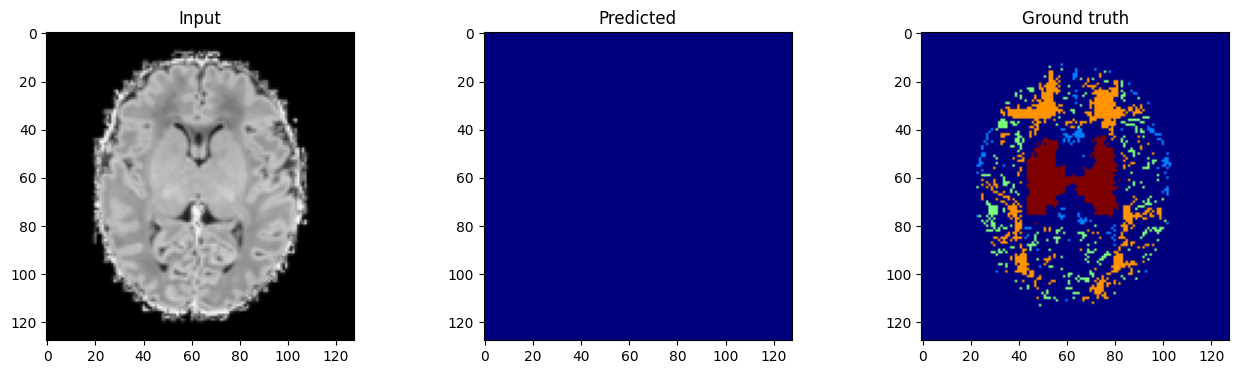

Epoch 25 - Loss on training set: 0.87, Loss on validation set: 0.87


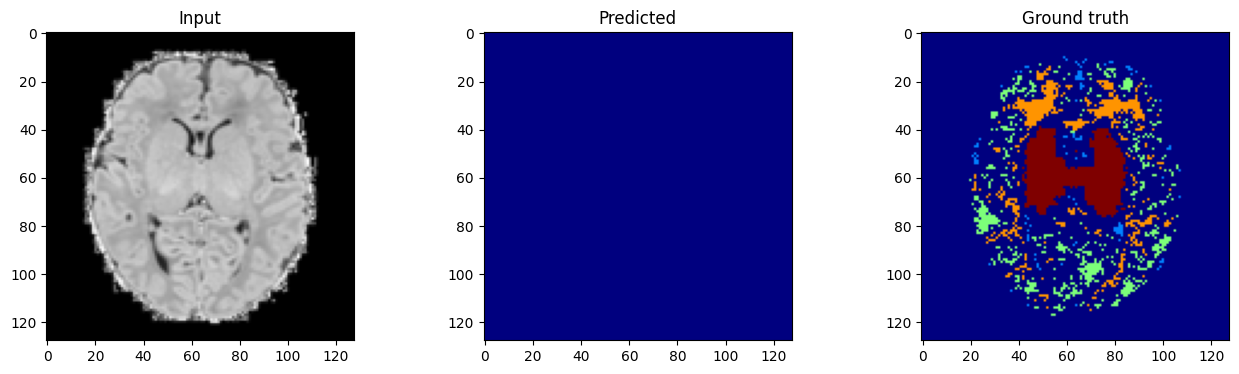

Epoch 30 - Loss on training set: 0.87, Loss on validation set: 0.87


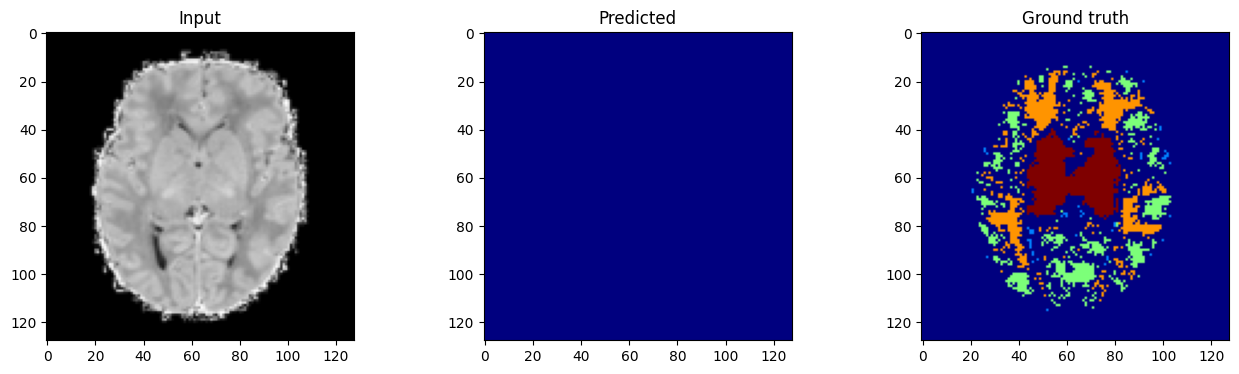

Epoch 35 - Loss on training set: 0.87, Loss on validation set: 0.87


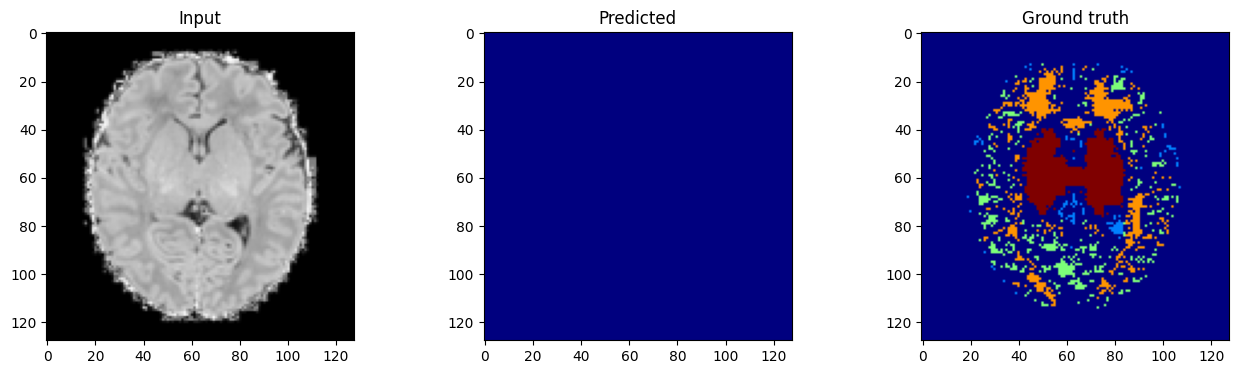

Epoch 40 - Loss on training set: 0.87, Loss on validation set: 0.87


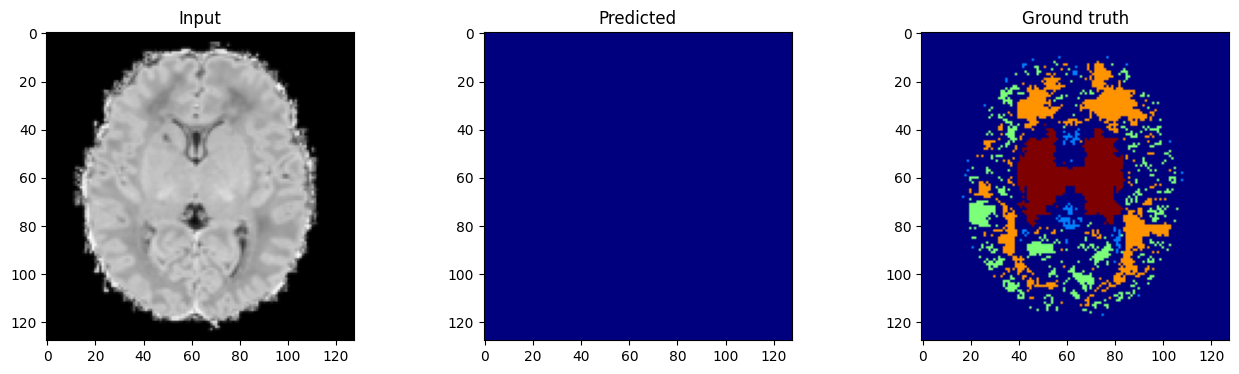

Epoch 45 - Loss on training set: 0.87, Loss on validation set: 0.87


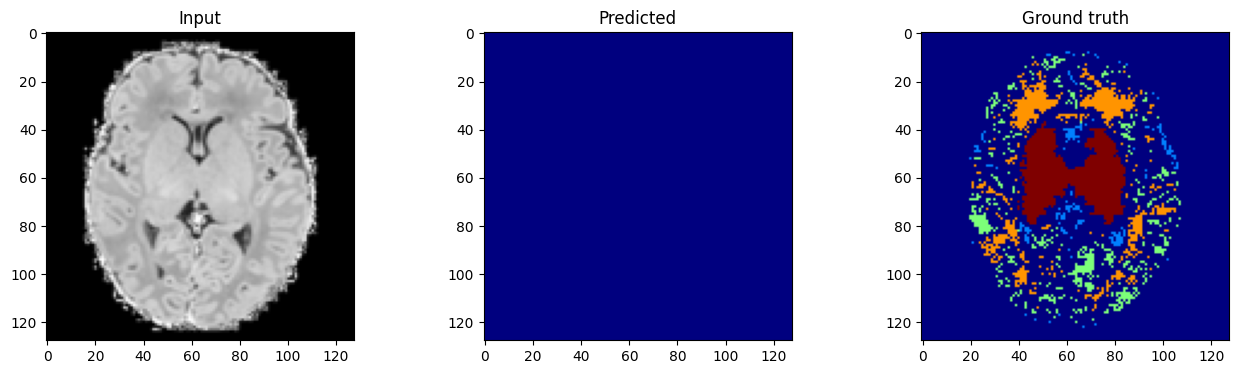

Epoch 50 - Loss on training set: 0.87, Loss on validation set: 0.87


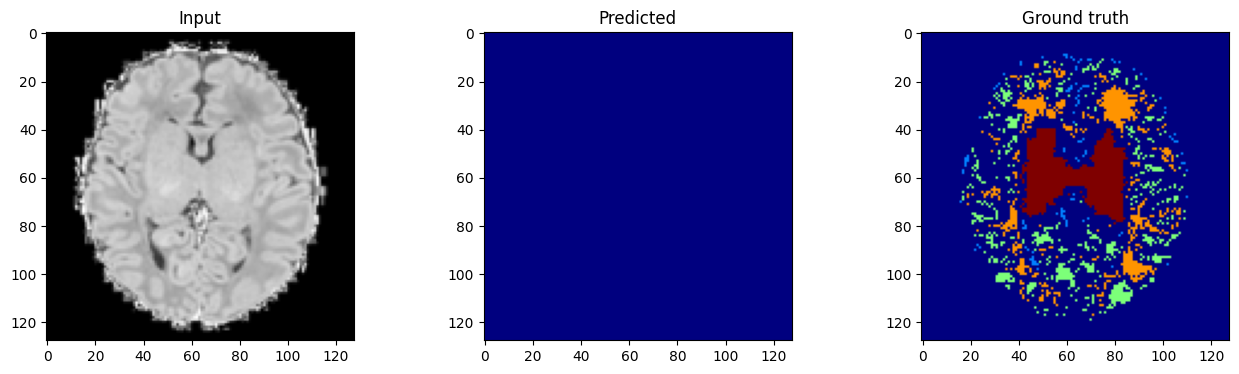

Epoch 55 - Loss on training set: 0.87, Loss on validation set: 0.87


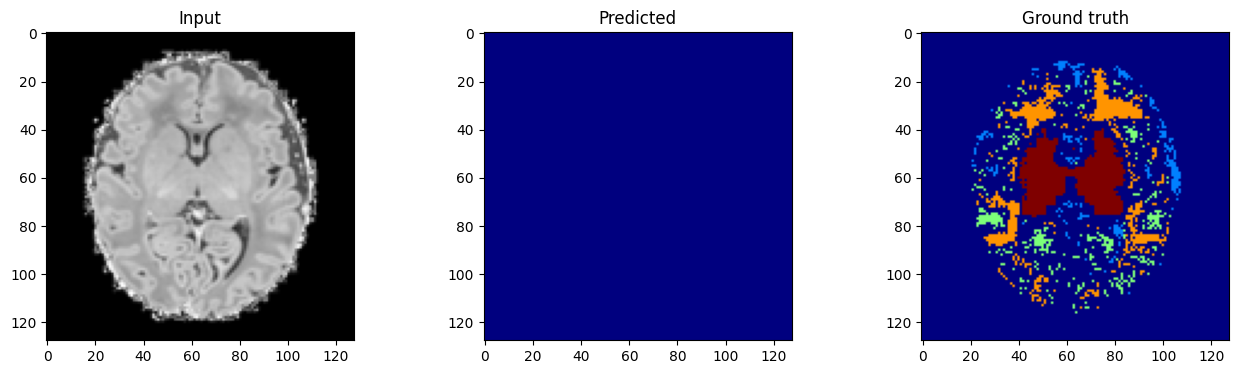

Epoch 60 - Loss on training set: 0.87, Loss on validation set: 0.88


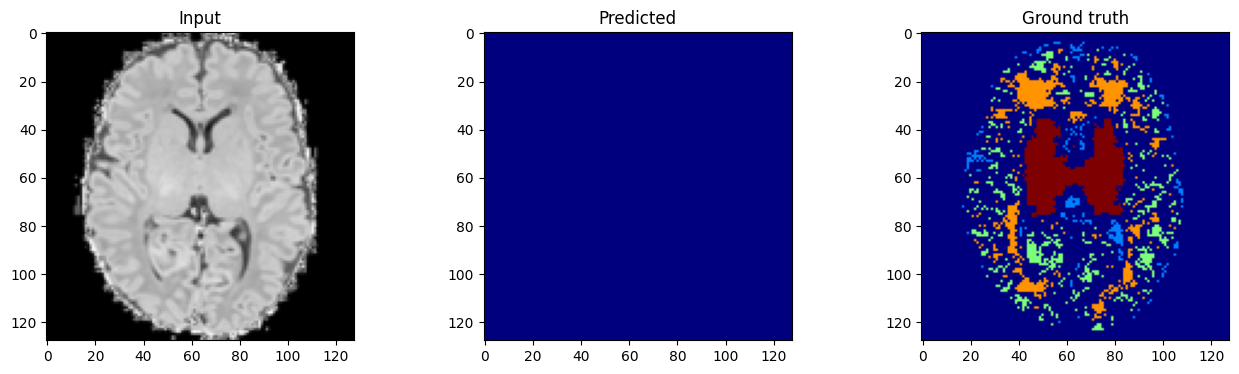

Epoch 65 - Loss on training set: 0.87, Loss on validation set: 0.87


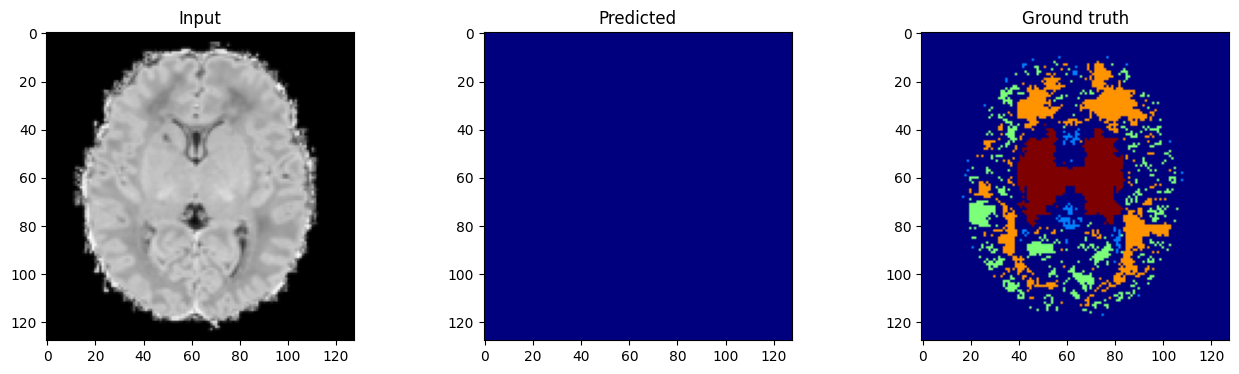

Epoch 70 - Loss on training set: 0.87, Loss on validation set: 0.88


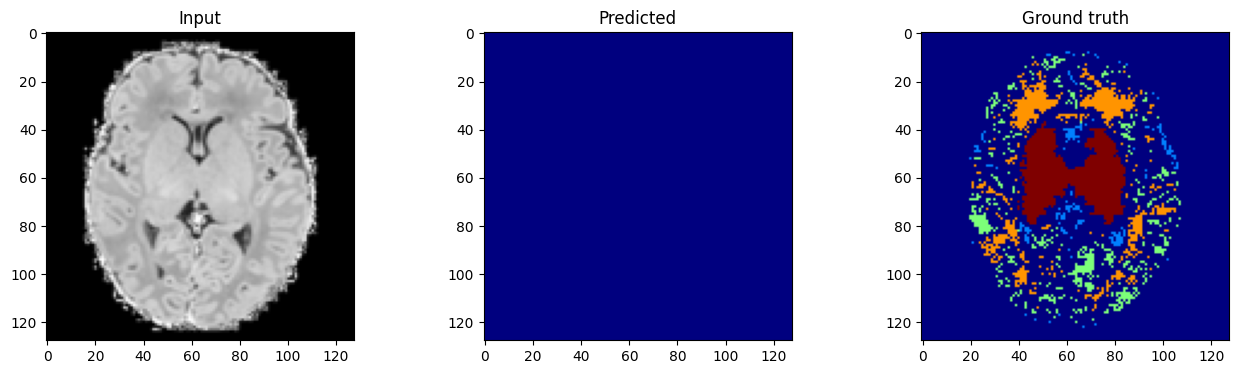

Epoch 75 - Loss on training set: 0.87, Loss on validation set: 0.88


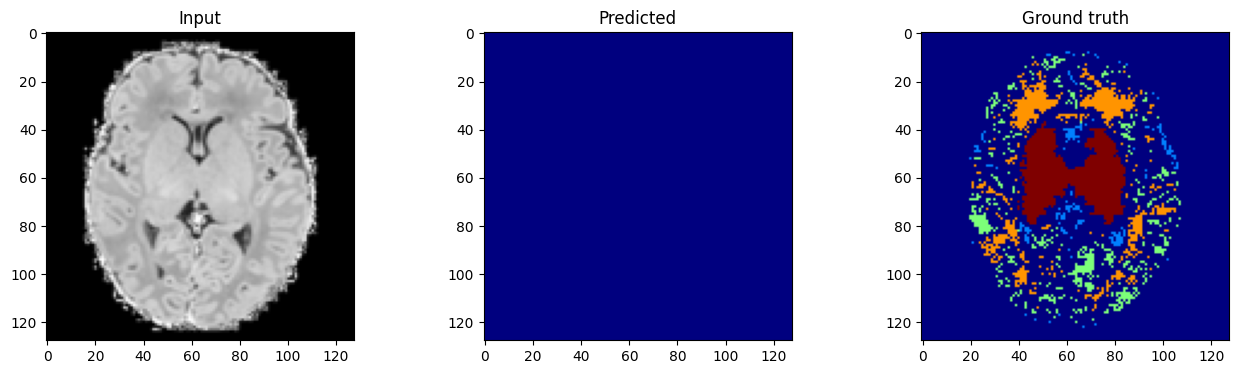

Training time: 1.0 minutes 35 seconds.


In [47]:
# Implement the training and validation loops
# Complete the code below

# To keep track of training time
import time
time_start = time.time()

# Variables for training
n_epochs = 80
learning_rate = 0.005

# Loss function and optimizer
loss_function = DiceLoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Metrics to store during training
train_loss_epochs = []
val_loss_epochs = []


# Iterate over the epochs
for epoch in range(0, n_epochs):

  # Temporary variable to store loss for each batch
  train_loss_batch = []
  val_loss_batch = []

  # Implement training and validation phases
  for phase in ['train', 'valid']:
    if phase == 'train':
      model.train()
      dataloader = dataloaders['train']
    else:
      model.eval()
      dataloader = dataloaders['valid']

    # Load batches and push to device
    for i, data in enumerate(dataloader):
      # Image data
      img_input = data['image'].to(device)

      # Segmentation ground truth
      seg_gt = data['seg'].to(device)

      # Training loop
      if phase == 'train':
        optim.zero_grad()
        # Forward pass
        x_out = model(img_input)

        # Calculate loss
        loss = loss_function(seg_gt, x_out)

        # Store batch training loss
        train_loss_batch.append(loss.item())

        # Backward pass
        loss.backward()

        # Update weights
        optim.step()


      # Validation loop
      if phase == 'valid':
        # Set model to evaluation mode

        # Prediction is done without gradients
        with torch.no_grad():
          x_out_val = model(img_input)

          # Calculate loss
          loss_v = loss_function(seg_gt, x_out_val)

          # Store batch validation loss
          val_loss_batch.append(loss_v.item())

          # Plot once every 5 epochs
          if epoch % 5 == 0 and i == 0:
            print(f'Epoch {epoch} - Loss on training set: {round(np.mean(train_loss_batch), 2)}, Loss on validation set: {round(np.mean(val_loss_batch),2)}')

            plt.figure(figsize=(16, 4))

            plt.subplot(1,3,1)
            # Visualize input image
            plt.title('Input')
            plt.imshow(img_input[0, 0].cpu().numpy(), cmap='gray')

            plt.subplot(1,3,2)
            # Visualize predicted segmentation (choose one of the channels)
            plt.title('Predicted')
            pred_seg = torch.argmax(x_out_val[0], dim=0)
            plt.imshow(pred_seg.cpu(), cmap='jet')

            plt.subplot(1,3,3)
            # Visualize ground truth segmentation (same channel)
            plt.title('Ground truth')
            gt_seg = torch.argmax(seg_gt[0], dim=0)
            plt.imshow(gt_seg.cpu(), cmap='jet')

            plt.show()

  # Store losses for the epoch (average of the batch loss)
  train_loss_epochs.append(np.mean(train_loss_batch))
  val_loss_epochs.append(np.mean(val_loss_batch))

# Print training time
print(f'Training time: {(time.time() - time_start) // 60} minutes {round((time.time() - time_start) % 60)} seconds.')

Plot the losses

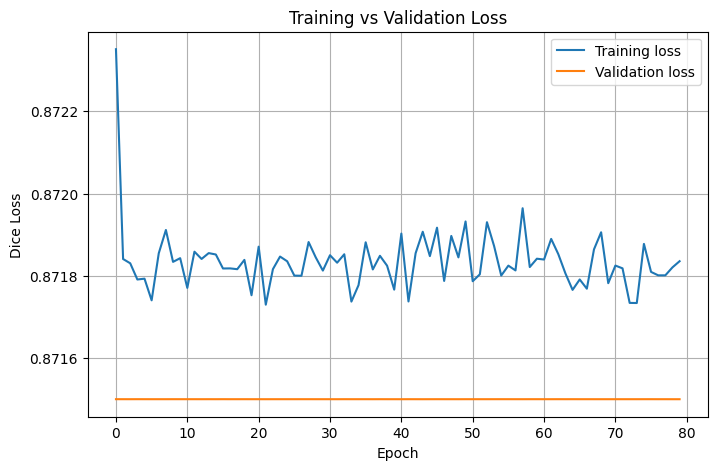

In [48]:
# Plot the losses on training and validation sets
plt.figure(figsize=(8, 5))

plt.plot(train_loss_epochs, label='Training loss')
plt.plot(val_loss_epochs, label='Validation loss')

plt.title("Training vs Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.grid(True)

plt.show()

## Step 7: Predict on the test set and visualize


Complete the function `plot_image_gtseg_predseg()`.

In [49]:
# Define the function for visualization
def plot_image_gtseg_predseg(img_, seg_gt_, seg_pr_):

  plt.figure(figsize=(20, 6))

  # Visualize input image
  plt.subplot(2, 6, 1)
  plt.title('Input Image')
  plt.imshow(img_)
  plt.axis('off')

  for idx in np.arange(0, 5):
    # Visualize ground truth segmentations
    plt.subplot(2, 6, idx+2)
    plt.imshow(seg_gt_[:, :, idx], cmap='gray')
    plt.axis('off')
    plt.title(f"GT: {LABELS_DICT[idx]}")  # Remember LABELS_DICT defined in Step 3

    # Predictions
    plt.subplot(2, 6, idx+2+6)
    # Visualize predicted segmentations
    plt.imshow(seg_pr_[:, :, idx], cmap='gray')
    plt.axis('off')
    plt.title(f"Pred: {LABELS_DICT[idx]}")  # Remember LABELS_DICT defined in Step 3

  plt.tight_layout()
  plt.show()

Predict with the trained model on the test dataset and use the plotter function to visualize the predictions for the first 3 samples.

Test loss: 0.73


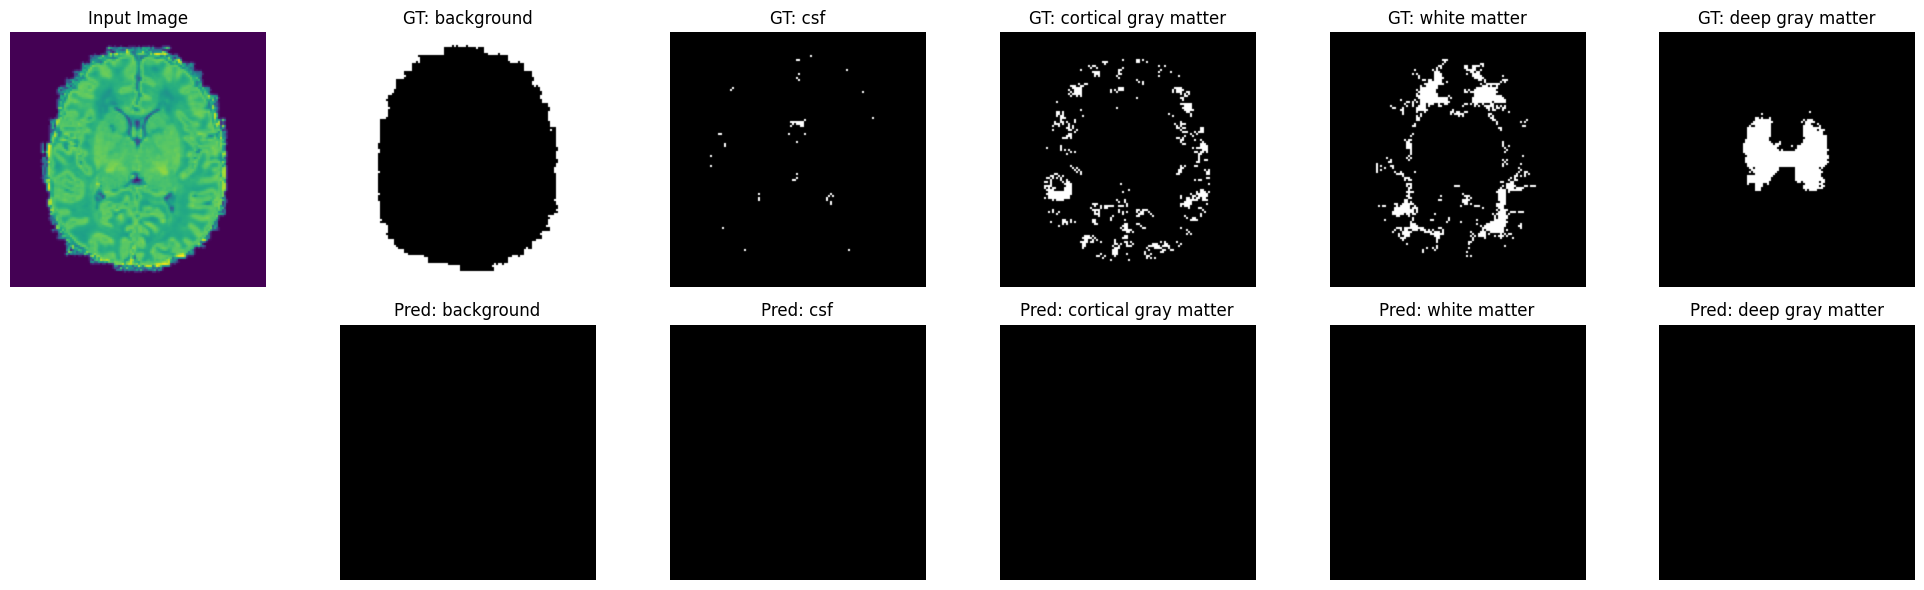

Test loss: 0.73


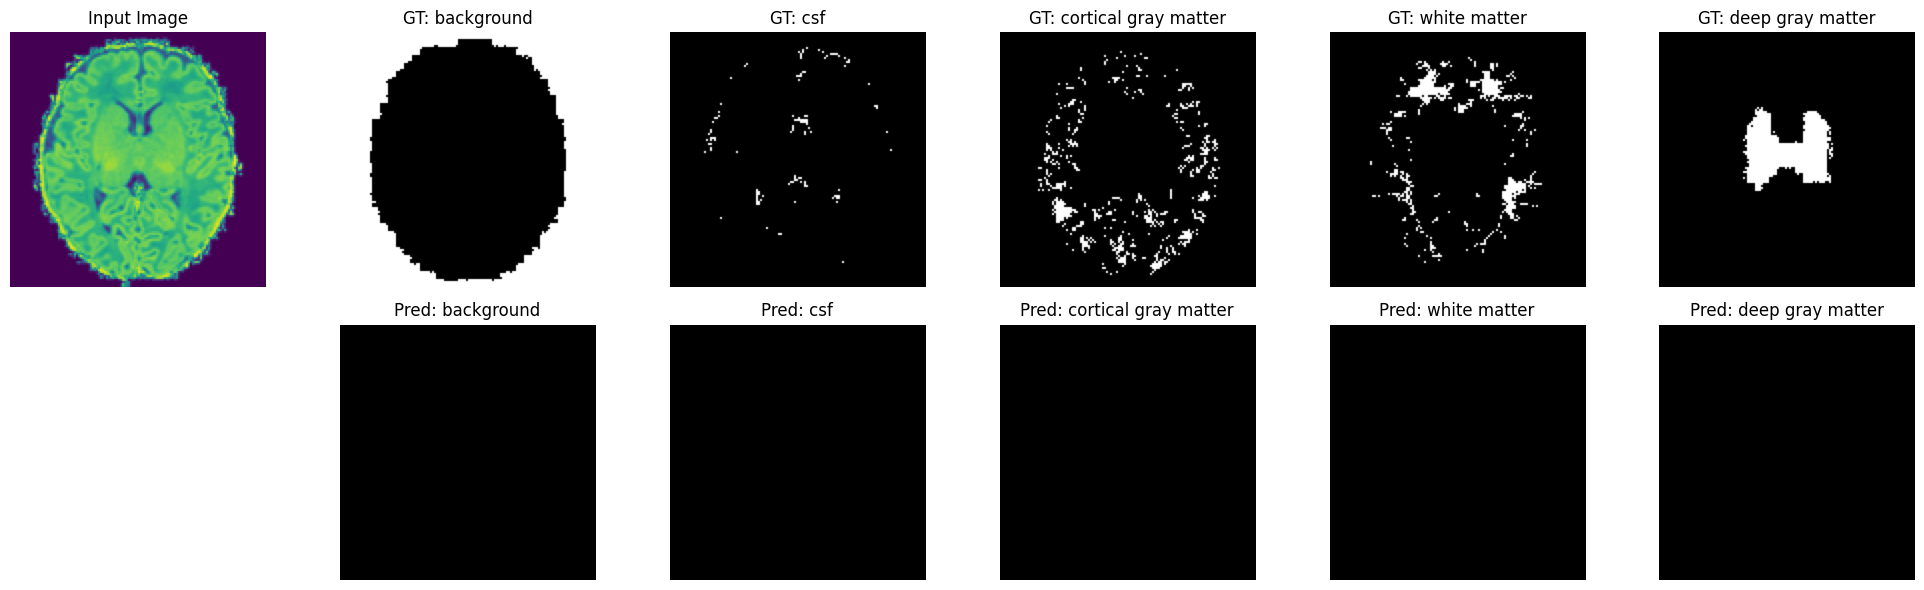

Test loss: 0.73


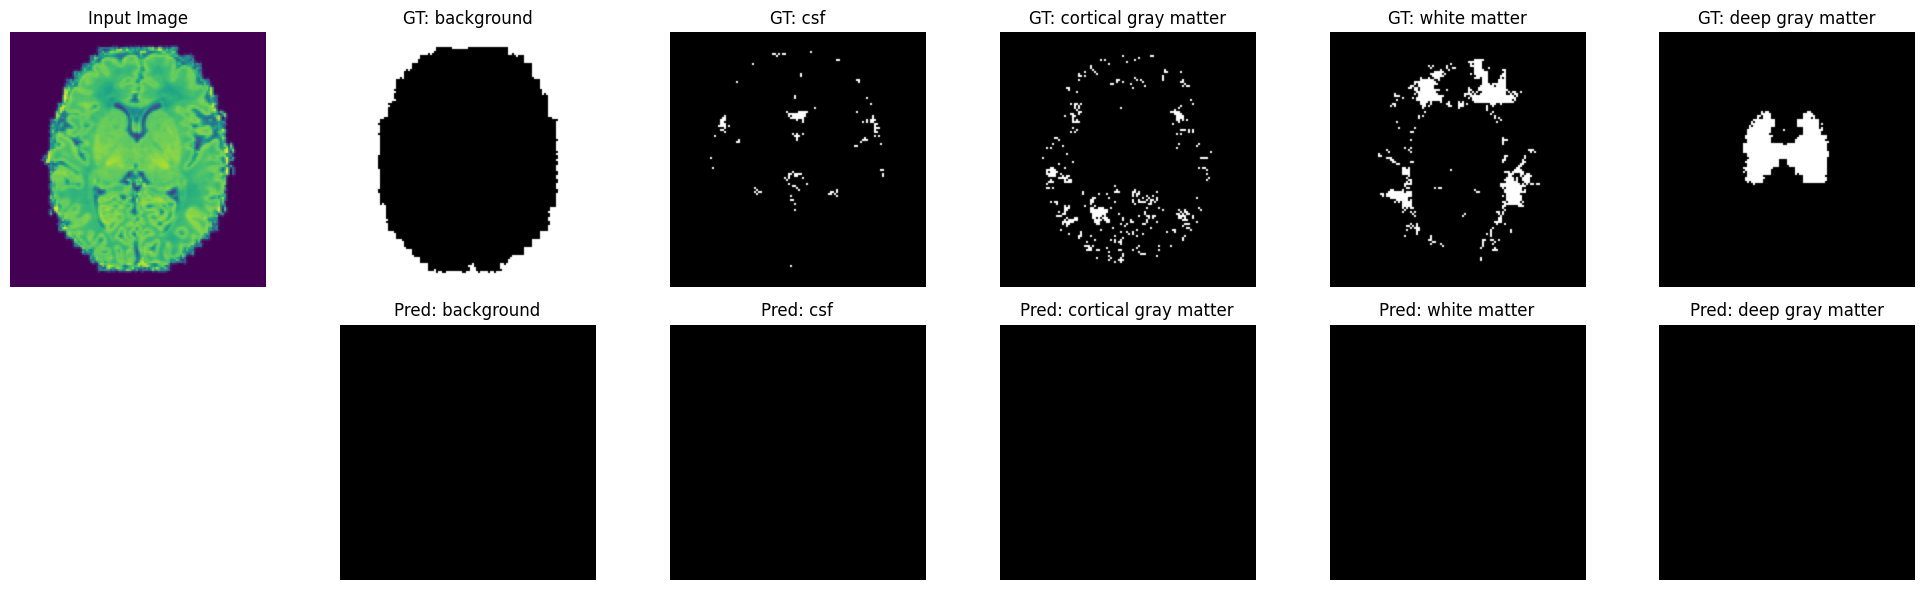

In [50]:
#Define loss fuction if missing
criterion = torch.nn.CrossEntropyLoss()
# Predict with the trained model on the test dataset
model.eval()
with torch.no_grad():
  for i, data in enumerate(dataloaders['test']):
    # Image data
    img_input = data['image'].to(device)

    # Segmentation ground truth
    seg_gt = data['seg'].to(device)

    # Forward pass
    x_out_test = model(img_input)

    # Calculate loss
    loss_test = criterion(x_out_test, seg_gt)

    # Visualize firs three samples of first batch
    if i == 0:
      for idx in np.arange(0, 3):
        print(f'Test loss: {round(loss_test.item(),2)}')

        # Convert image back to numpy (H, W, 3)
        img_np = img_input[idx].permute(1, 2, 0).cpu().numpy()

        # Convert GT segmentation to numpy  (H, W, num_classes)
        seg_gt_np = seg_gt[idx].permute(1, 2, 0).cpu().numpy()

        # Convert predicted segmentation
        pred_argmax = torch.argmax(x_out_test[idx], dim=0)    # (H, W)
        num_classes = x_out_test.shape[1]

        # Convert into one-hot prediction (H, W, C)
        seg_pred_np = np.zeros((pred_argmax.shape[0],
                                pred_argmax.shape[1],
                                num_classes))

        for c in range(num_classes):
          seg_pred_np[:, :, c] = (pred_argmax.cpu().numpy() == c)

        #Plot
        plot_image_gtseg_predseg(img_np, seg_gt_np, seg_pred_np)

    #Only visualize the first batch
    if i > 0:
      break

## Step 8: Implement Early Stopping


Retrain the network with early stopping and save the best model.

In [51]:
# Early stopping parameters
patience = 10
patience_counter = 0
best_val_loss = float('inf')

# To keep track of training time
import time
time_start = time.time()

# Variables for training
n_epochs = 80
learning_rate = 0.005

# Loss function and optimizer
loss_function = DiceLoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Metrics to store during training
train_loss_epochs = []
val_loss_epochs = []

print("Starting training...")

# Iterate over epochs
for epoch in range(n_epochs):

    train_loss_batch = []
    val_loss_batch = []

    for phase in ['train', 'valid']:

        if phase == 'train':
            model.train()
            dataloader = dataloaders['train']
        else:
            model.eval()
            dataloader = dataloaders['valid']

        for i, data in enumerate(dataloader):
            img_input = data['image'].to(device)
            seg_gt = data['seg'].to(device)

            if phase == 'train':
                optim.zero_grad()
                x_out = model(img_input)
                loss = loss_function(seg_gt, x_out)

                train_loss_batch.append(loss.item())

                loss.backward()
                optim.step()

            else:  # validation
                with torch.no_grad():
                    x_out_val = model(img_input)
                    loss_v = loss_function(seg_gt, x_out_val)
                    val_loss_batch.append(loss_v.item())

    # Average losses
    epoch_train_loss = sum(train_loss_batch) / len(train_loss_batch)
    epoch_val_loss = sum(val_loss_batch) / len(val_loss_batch)

    train_loss_epochs.append(epoch_train_loss)
    val_loss_epochs.append(epoch_val_loss)

    print(f"Epoch {epoch}: Train Loss = {epoch_train_loss:.4f}, Valid Loss = {epoch_val_loss:.4f}")

    #Early Stopping logic
    if epoch_val_loss < best_val_loss:
        print(f"  → Validation loss improved from {best_val_loss:.4f} to {epoch_val_loss:.4f}. Saving model...")
        best_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        patience_counter += 1
        print(f"  → No improvement. Patience: {patience_counter}/{patience}")

    # Stop training if patience exceeded
    if patience_counter >= patience:
        print("Early stopping triggered! Training stopped.")
        break


print(f"Training completed. Total time: {(time.time() - time_start)/60:.2f} minutes.")


Starting training...
Epoch 0: Train Loss = 0.8719, Valid Loss = 0.8715
  → Validation loss improved from inf to 0.8715. Saving model...
Epoch 1: Train Loss = 0.8719, Valid Loss = 0.8715
  → No improvement. Patience: 1/10
Epoch 2: Train Loss = 0.8717, Valid Loss = 0.8715
  → No improvement. Patience: 2/10
Epoch 3: Train Loss = 0.8717, Valid Loss = 0.8715
  → No improvement. Patience: 3/10
Epoch 4: Train Loss = 0.8719, Valid Loss = 0.8715
  → No improvement. Patience: 4/10
Epoch 5: Train Loss = 0.8719, Valid Loss = 0.8715
  → Validation loss improved from 0.8715 to 0.8715. Saving model...
Epoch 6: Train Loss = 0.8718, Valid Loss = 0.8715
  → No improvement. Patience: 1/10
Epoch 7: Train Loss = 0.8719, Valid Loss = 0.8715
  → No improvement. Patience: 2/10
Epoch 8: Train Loss = 0.8718, Valid Loss = 0.8715
  → No improvement. Patience: 3/10
Epoch 9: Train Loss = 0.8718, Valid Loss = 0.8715
  → No improvement. Patience: 4/10
Epoch 10: Train Loss = 0.8719, Valid Loss = 0.8715
  → No improvem

## Step 9: Implement BatchNorm and Early Stopping


Change the architecture of the network to introduce BatchNorm.

In [52]:
class MyConvNetwork_BN(nn.Module):
    def __init__(self, in_channels=1, out_nodes=5):
        super(MyConvNetwork_BN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.bn_up1 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, out_nodes, kernel_size=1)

    def forward(self, x):

        # Encoder
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))

        # Decoder
        x = F.relu(self.bn_up1(self.up1(x)))

        # Output logits
        x = self.conv3(x)
        return x


Retrain the network with early stopping and BatchNorm. Save the best model.

In [53]:
# Instantiate new model with BatchNorm
model_bn = MyConvNetwork_BN(in_channels=1, out_nodes=5).to(device)

# Loss and optimizer
loss_function = DiceLoss()
optim = torch.optim.Adam(model_bn.parameters(), lr=0.005)

# Early stopping parameters
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# Track losses
train_loss_epochs = []
val_loss_epochs = []

print("Training with BatchNorm + Early Stopping...")

import time
time_start = time.time()

# Training loop
for epoch in range(80):

    train_loss_batch = []
    val_loss_batch = []

    for phase in ['train', 'valid']:
        if phase == 'train':
            model_bn.train()
            dataloader = dataloaders['train']
        else:
            model_bn.eval()
            dataloader = dataloaders['valid']

        for i, data in enumerate(dataloader):

            # Input image
            img_input = data['image'].to(device)
            # Ground truth segmentation
            seg_gt = data['seg'].to(device)

            if phase == 'train':
                optim.zero_grad()

                x_out = model_bn(img_input)
                loss = loss_function(seg_gt, x_out)

                train_loss_batch.append(loss.item())

                loss.backward()
                optim.step()

            else:
                with torch.no_grad():
                    x_out_val = model_bn(img_input)
                    loss_v = loss_function(seg_gt, x_out_val)

                    val_loss_batch.append(loss_v.item())

    # Epoch mean loss
    train_loss = sum(train_loss_batch) / len(train_loss_batch)
    val_loss = sum(val_loss_batch) / len(val_loss_batch)

    train_loss_epochs.append(train_loss)
    val_loss_epochs.append(val_loss)

    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        print("  → Improved! Saving best_model_batchnorm.pth")
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model_bn.state_dict(), "best_model_batchnorm.pth")
    else:
        patience_counter += 1
        print(f"  → No improvement ({patience_counter}/{patience})")

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

print(f"Training time: {(time.time() - time_start) // 60} min {round((time.time() - time_start) % 60)} sec")


Training with BatchNorm + Early Stopping...
Epoch 0 - Train Loss: 0.7373, Valid Loss: 0.8320
  → Improved! Saving best_model_batchnorm.pth
Epoch 1 - Train Loss: 0.3803, Valid Loss: 0.6463
  → Improved! Saving best_model_batchnorm.pth
Epoch 2 - Train Loss: 0.5301, Valid Loss: 0.4321
  → Improved! Saving best_model_batchnorm.pth
Epoch 3 - Train Loss: 0.4389, Valid Loss: 0.3564
  → Improved! Saving best_model_batchnorm.pth
Epoch 4 - Train Loss: 0.2830, Valid Loss: 0.1699
  → Improved! Saving best_model_batchnorm.pth
Epoch 5 - Train Loss: -0.0988, Valid Loss: -3.0093
  → Improved! Saving best_model_batchnorm.pth
Epoch 6 - Train Loss: 0.5965, Valid Loss: 0.9515
  → No improvement (1/10)
Epoch 7 - Train Loss: 0.9736, Valid Loss: 0.9507
  → No improvement (2/10)
Epoch 8 - Train Loss: 0.9411, Valid Loss: 0.9265
  → No improvement (3/10)
Epoch 9 - Train Loss: 0.9118, Valid Loss: 0.8927
  → No improvement (4/10)
Epoch 10 - Train Loss: 0.8379, Valid Loss: 0.9356
  → No improvement (5/10)
Epoch 11

## Step 10: Compare the performance on the test set with and without BatchNorm and discuss briefly (200 words max.)

The performance on the test set with BatchNorm showed less overfitting. Another thing is that the model learned faster with BatchNorm compared to the same model without BatchNorm.